# Exercise 7: Denoising Diffusion Probabilistic Models

Submitted by:

 ** Faisal Omari 325616894

 ** Fadi Khatib 308052992

### Load libraries and utils

In [63]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
import math

import os

# Visualization tools
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Seed set to 42


Using device cuda:0


In [64]:
def show_tensor_image(img):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(img))

def trim_imgs(imgs, skip=10):
    imgs = imgs.view((-1,) + imgs.shape[2:])        # BATCH * T, CH, WIDTH, HEIGHT
    imgs = imgs[::skip]
    return imgs

### Load MNIST

In [65]:
IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128

def load_MNIST(data_transform, train=True):
    return torchvision.datasets.MNIST(
        "./",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_MNIST():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_MNIST(data_transform, train=True)
    test_set = load_MNIST(data_transform, train=False)
    return train_set, test_set

train, test = load_transformed_MNIST()
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

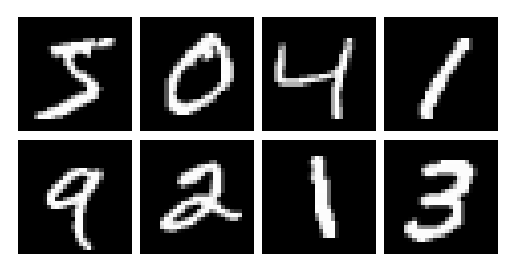

In [66]:
def show_imgs(imgs, nrows=1, grid=True):
    ncols = len(imgs) // nrows

    imgs = torch.stack(imgs) if isinstance(imgs, list) else imgs
    imgs = imgs.unsqueeze(1) if imgs.dim() == 3 else imgs

    if grid:
        grid = torchvision.utils.make_grid(imgs.cpu(), nrow=ncols, pad_value=128)
        show_tensor_image(grid.detach().cpu())
    else:
        ncols = len(imgs) // nrows
        for idx, img in enumerate(imgs):
            plt.subplot(nrows, ncols, idx + 1)
            plt.axis('off')
            show_tensor_image(img.detach().cpu())

    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train[i][0] for i in range(8)], nrows=2)

## Define the architercture

<img width="70%" src="https://sharon.srworkspace.com/dgm/time.png"/>

In [67]:
#@title Net components

class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        #x = x[:, None]
        return self.model(x)

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.model(x)

class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(2 * in_chs, out_chs, 3, 2, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        )

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [68]:
class UNet(nn.Module):
    def __init__(self, T):
        super(UNet, self).__init__()
        self.T = T

        img_chs = IMG_CH
        down_chs = (64, 128, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        self.latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)

        # New
        t_embed_dim = 8

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*self.latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*self.latent_image_size**2),
            nn.ReLU()
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim) # New
        self.temb_1 = EmbedBlock(t_embed_dim, up_chs[1]) # New
        self.temb_2 = EmbedBlock(t_embed_dim, up_chs[2]) # New

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], self.latent_image_size, self.latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[2], up_chs[2], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

        print("Net Num params: ", sum(p.numel() for p in self.parameters()))

    def forward(self, x, t):
        # Implement here
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / self.T
        t_emb = self.sinusoidaltime(t)
        temb_1 = self.temb_1(t_emb)
        temb_2 = self.temb_2(t_emb)
        x = self.up0(latent_vec)
        x= self.up1(down2,x)
        x= self.up2(down1,x+temb_1)
        x= self.out(torch.cat((down0, x+temb_2), dim=1))
        # x = self.up1(x + temb_1, down2)
        # print("up1: ", x.shape)
        # x = self.up2(x + temb_2, down1)
        # print("up2: ", x.shape)
        # x = self.out(torch.cat((x, down0), dim=1))
        
        return x

## Define DDPM model

A fundemantal idea of diffusion models is to add a little noise to the image each time step and learn how to remove it, depending on time. Here, we will use variance schedule.

<img width="70%" src="https://sharon.srworkspace.com/dgm/dog.png"/>

In [69]:
class DDPM(pl.LightningModule):
    def __init__(self, T=1000, method='cosine'):
        super(DDPM, self).__init__()
        self.T = T

        epsilon=0.008
        if method == 'cosine':
            steps=torch.linspace(0,T,steps=T+1).to(device)
            f_t=torch.cos(((steps/T+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
            self.Beta = torch.clip(1.0-f_t[1:]/f_t[:T], 0.0, 0.999)

        elif method == 'linear':
            self.Beta = torch.linspace(1e-4, 2e-2, T).to(device)

        # Forward diffusion variables
        self.a = 1.0 - self.Beta
        self.a_bar = torch.cumprod(self.a, dim=0)

        self.net = UNet(T)

        # Logging
        self.train_loss = []
        self.train_loss_in_epoch = []

        self.validation_loss = []
        self.validation_loss_in_epoch = []

    def forward(self, x, t):
        return self.net(x, t)

    def q(self, x_0, t):
        """
        Samples a new image from q
        Returns the noise applied to an image at timestep t
        x_0: the original image
        t: timestep
        """
        # Implement here
        noise = torch.randn_like(x_0)
        alpha_bar = self.a_bar[t].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def get_x0_pred(self, x_t, t, e_t):
        x_0_pred = (x_t - torch.sqrt(1 - self.a_bar[t]) * e_t) / torch.sqrt(self.a_bar[t])
        x_0_pred.clamp_(-1, 1)
        return x_0_pred

    @torch.no_grad()
    def reverse_q(self, x_t, t, e_t):
        # Implement here
        beta_t = self.Beta[t].view(-1, 1, 1, 1)
        alpha_t = self.a[t].view(-1, 1, 1, 1)
        alpha_bar_t = self.a_bar[t].view(-1, 1, 1, 1)
        m = x_t - ((1-alpha_t)/torch.sqrt(1-alpha_bar_t)) * e_t

        if t > 0:
            z = torch.randn_like(x_t)
        else:
            z = torch.zeros_like(x_t)

        out = 1/torch.sqrt(alpha_t) * m + beta_t * z
        return out

    def get_loss(self, x_0, t):
        """
        Returns the loss between the true noise and the predicted noise
        x_0: the original image
        t: timestep
        """
        # Implement here
        x_t, noise = self.q(x_0, t)
        e_t = self.net(x_t, t)
        loss = F.mse_loss(noise, e_t)
        return loss

    @torch.no_grad()
    def sample(self, num_imgs=1, y=None, ymask=None, scale=1.):
        # Implement here
        if y is None and ymask is None:
            output = torch.randn((num_imgs, 1, 28, 28), device=self.device)  # Start from pure noise
            for t in reversed(range(self.T)):
                t_tensor = torch.tensor([t], device=self.device)
                epsilon_t = self.net(output, t_tensor)
                output = self.reverse_q(output, t_tensor, epsilon_t)
            return output
        else:
            x_t = torch.randn_like(y, device=self.device)  # Start from pure noise
            for t in reversed(range(self.T)):
                t_tensor = torch.tensor([t], device=self.device)
                epsilon_t = self.net(x_t, t_tensor)
                x_0_pred = self.get_x0_pred(x_t, t_tensor, epsilon_t)
                correction = -scale * torch.sum(ymask * (x_0_pred - y), dim=(1, 2, 3), keepdim=True)
                x_t = self.reverse_q(x_t, t_tensor, epsilon_t + correction)
            return x_t

    # Lightning Configurations

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x = batch[0].to(device)
        t = torch.randint(0, self.T, (BATCH_SIZE,), device=device)

        loss = self.get_loss(x, t)
        self.train_loss_in_epoch.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0].to(device)
        t = torch.randint(0, self.T, (BATCH_SIZE,), device=device)

        loss = self.get_loss(x, t)
        self.validation_loss_in_epoch.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.tensor(self.train_loss_in_epoch).mean()
        self.train_loss_in_epoch = []

        self.log("train_loss", avg_loss, prog_bar=True)
        self.train_loss.append(avg_loss.detach().item())

        print(f"Epoch {self.current_epoch} | Loss: {avg_loss.detach().item()} ")

    def on_validation_epoch_end(self):
        avg_loss = torch.tensor(self.validation_loss_in_epoch).mean()
        self.validation_loss_in_epoch = []

        self.log("val_loss", avg_loss, prog_bar=True)
        self.validation_loss.append(avg_loss.detach().item())

        sampled_data = trim_imgs(self.sample(), skip=100)
        show_imgs(sampled_data, grid=False)

    def complete_image(self, y, ymask):
        completed_image = self.sample(y=y, ymask=ymask)
        return y * (1 - ymask) + completed_image * ymask


Net Num params:  3019521


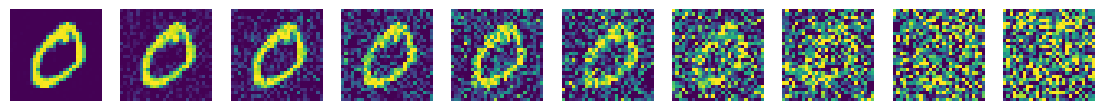

In [70]:
#@title you may run this to make sure your implementation for q is good

x_0 = train[1][0].to(device)  # Initial image
plt.figure(figsize=(14, 8))

T=1000
ddpm = DDPM(T)

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, noise = ddpm.q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    if t % 100 == 0:
      ax = plt.subplot(1, 10, t // 100 + 1)
      ax.axis('off')
      show_tensor_image(img)

## Train

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params | Mode 
--------------------------------------
0 | net  | UNet | 3.0 M  | train
--------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
12.078    Total estimated model params size (MB)


Net Num params:  3019521


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

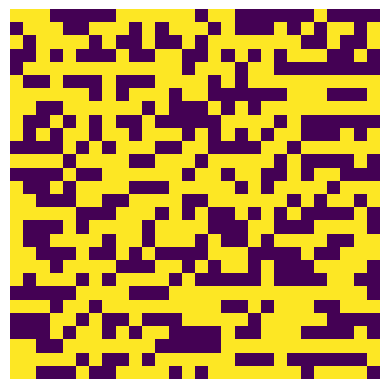

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

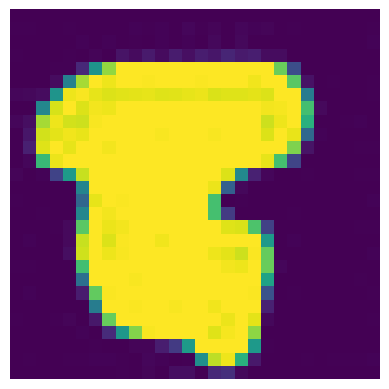

Epoch 0 | Loss: 0.14063197374343872 


Validation: |          | 0/? [00:00<?, ?it/s]

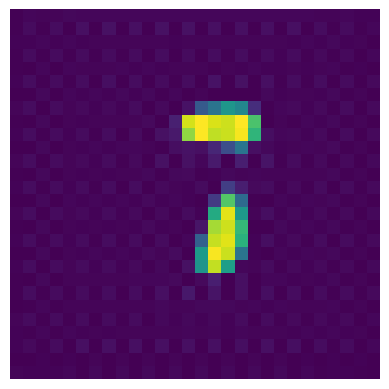

Epoch 1 | Loss: 0.08080006390810013 


Validation: |          | 0/? [00:00<?, ?it/s]

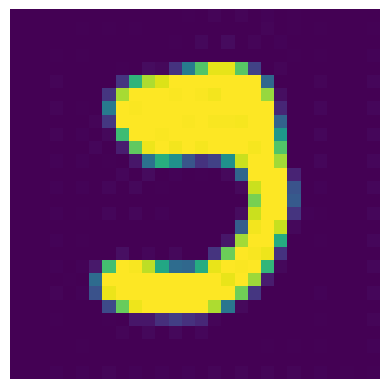

Epoch 2 | Loss: 0.06986896693706512 


Validation: |          | 0/? [00:00<?, ?it/s]

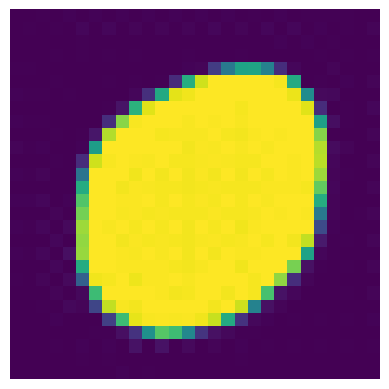

Epoch 3 | Loss: 0.06526069343090057 


Validation: |          | 0/? [00:00<?, ?it/s]

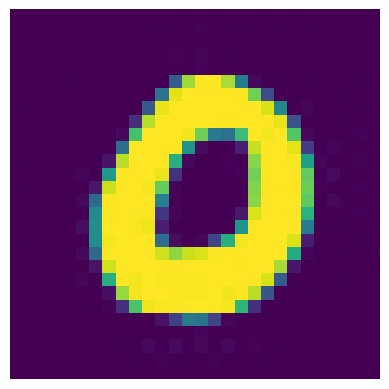

Epoch 4 | Loss: 0.06138774752616882 


Validation: |          | 0/? [00:00<?, ?it/s]

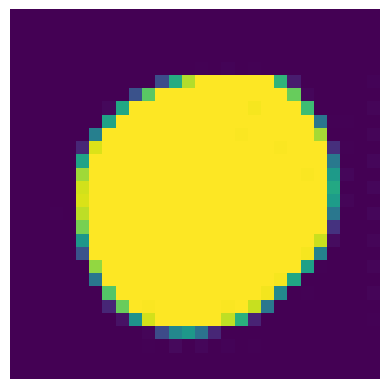

Epoch 5 | Loss: 0.058938831090927124 


Validation: |          | 0/? [00:00<?, ?it/s]

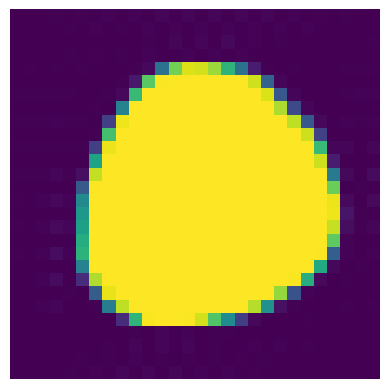

Epoch 6 | Loss: 0.05696453899145126 


Validation: |          | 0/? [00:00<?, ?it/s]

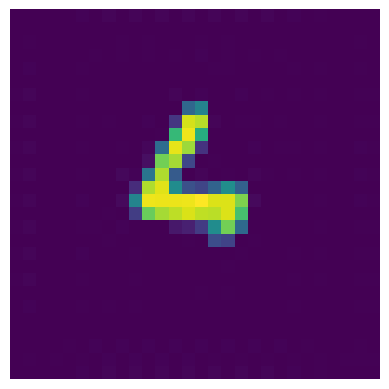

Epoch 7 | Loss: 0.05539455637335777 


Validation: |          | 0/? [00:00<?, ?it/s]

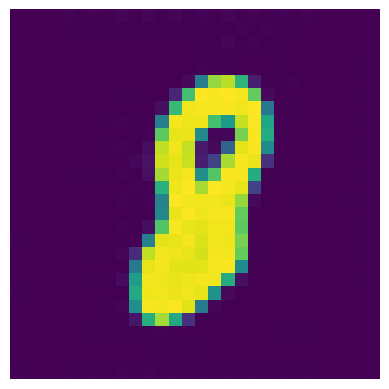

Epoch 8 | Loss: 0.05376839265227318 


Validation: |          | 0/? [00:00<?, ?it/s]

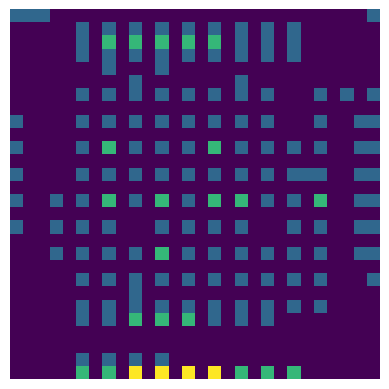

Epoch 9 | Loss: 0.05284731090068817 


Validation: |          | 0/? [00:00<?, ?it/s]

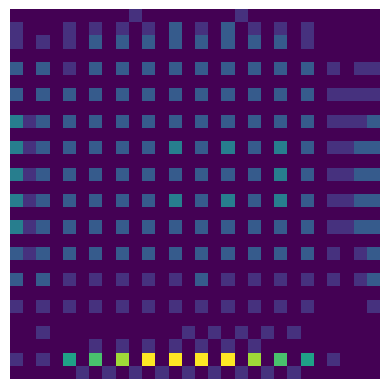

Epoch 10 | Loss: 0.053169507533311844 


Validation: |          | 0/? [00:00<?, ?it/s]

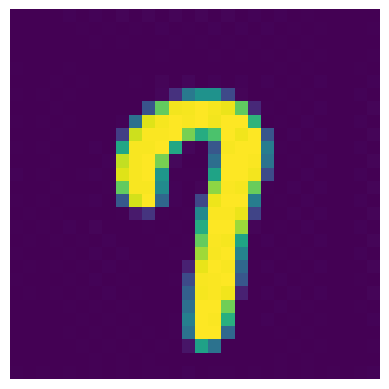

Epoch 11 | Loss: 0.05061022564768791 


Validation: |          | 0/? [00:00<?, ?it/s]

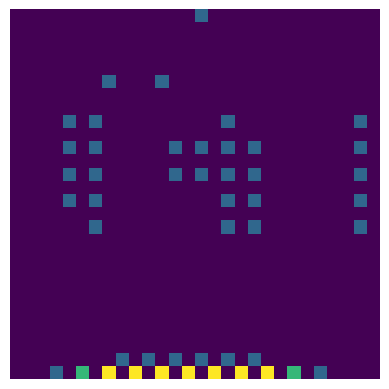

Epoch 12 | Loss: 0.05055948346853256 


Validation: |          | 0/? [00:00<?, ?it/s]

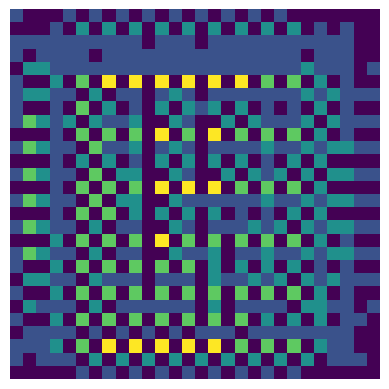

Epoch 13 | Loss: 0.04980774596333504 


Validation: |          | 0/? [00:00<?, ?it/s]

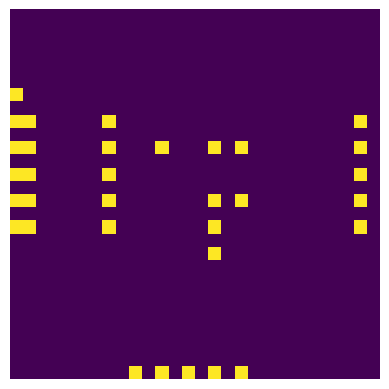

Epoch 14 | Loss: 0.04965679720044136 


Validation: |          | 0/? [00:00<?, ?it/s]

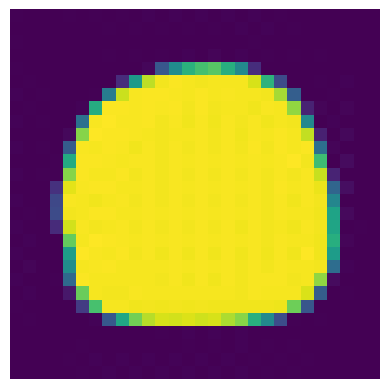

Epoch 15 | Loss: 0.04828907921910286 


Validation: |          | 0/? [00:00<?, ?it/s]

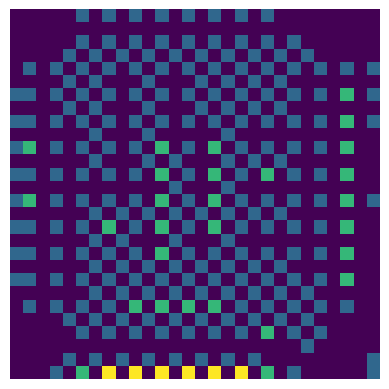

Epoch 16 | Loss: 0.04810115694999695 


Validation: |          | 0/? [00:00<?, ?it/s]

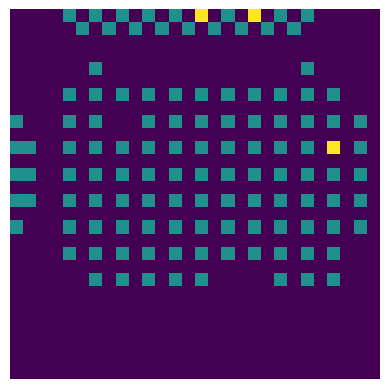

Epoch 17 | Loss: 0.04746316745877266 


Validation: |          | 0/? [00:00<?, ?it/s]

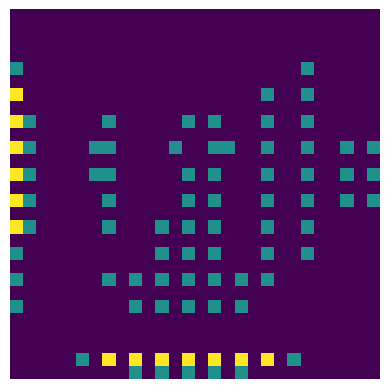

Epoch 18 | Loss: 0.04692285880446434 


Validation: |          | 0/? [00:00<?, ?it/s]

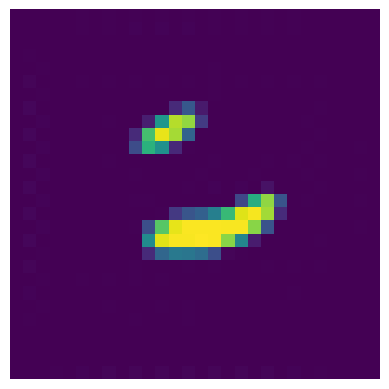

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19 | Loss: 0.04621254280209541 


In [71]:

torch.cuda.empty_cache()
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join("DDPM"),
        devices=1,
        max_epochs=20,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
            LearningRateMonitor("epoch")
        ]
    )

    model = DDPM(**kwargs)
    model.train()
    trainer.fit(model, train_dataloader, test_dataloader)
    model.eval()
    trainer.save_checkpoint('ddpm_model.ckpt')
    return model

model = train_model(T=1000).to(device)

Seed set to 1


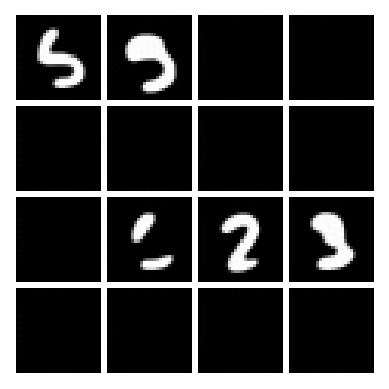

In [72]:
pl.seed_everything(1)
sampled_data = model.sample(16)[:, -1]               # Get the last time step for each image
show_imgs(sampled_data, nrows=4, grid=True)

In [73]:
torch.save(model.state_dict(), 'ddpm_model.pth')

## Autocomplete two images

Net Num params:  3019521


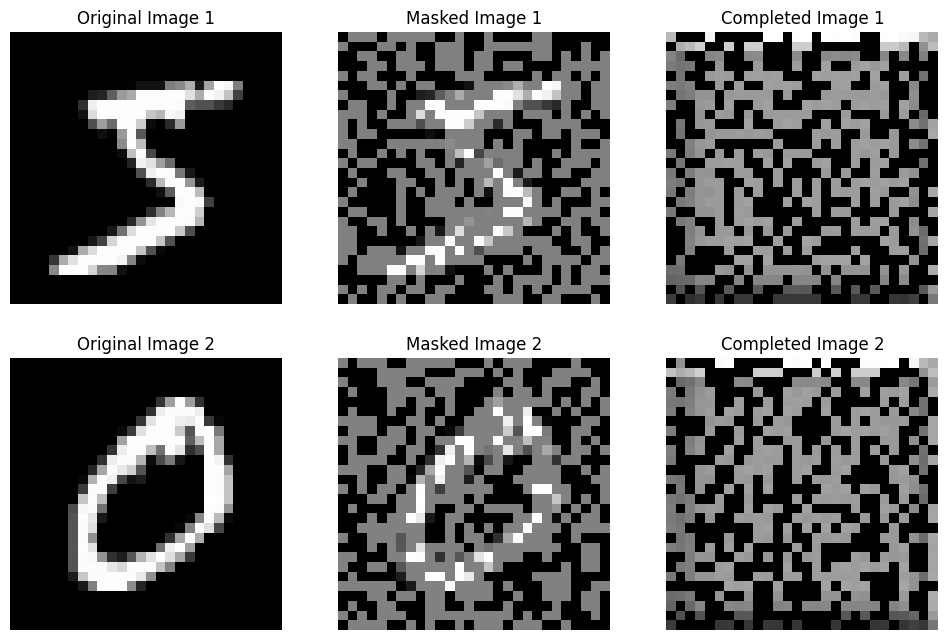

In [74]:
def create_masked_image(image, mask_fraction=0.5):
    mask = torch.ones_like(image)
    mask_area = int(mask_fraction * image.numel())
    mask_indices = torch.randperm(image.numel())[:mask_area]
    mask.view(-1)[mask_indices] = 0
    masked_image = image * mask
    return masked_image, mask

def show_tensor_image(image):
    image = image.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

def trim_imgs(images, skip):
    return images[::skip]

def show_imgs(images, grid=True):
    if grid:
        grid_img = torchvision.utils.make_grid(images, nrow=5)
        show_tensor_image(grid_img)
    else:
        for img in images:
            show_tensor_image(img)
            plt.show()

# Load two images from the training dataset
image1, _ = train[0]
image2, _ = train[1]

# Move images to the same device as your model
image1 = image1.to(device)
image2 = image2.to(device)

masked_image1, mask1 = create_masked_image(image1)
masked_image2, mask2 = create_masked_image(image2)

# Instantiate your model
model = DDPM(T=1000).to(device)
model.eval()

# Complete the images
completed_image1 = model.complete_image(y=masked_image1.unsqueeze(0), ymask=mask1.unsqueeze(0))
completed_image2 = model.complete_image(y=masked_image2.unsqueeze(0), ymask=mask2.unsqueeze(0))

# Remove batch dimension for visualization
completed_image1 = completed_image1.squeeze(0)
completed_image2 = completed_image2.squeeze(0)

# Show original, masked, and completed images
plt.figure(figsize=(12, 12))

plt.subplot(3, 3, 1)
show_tensor_image(image1)
plt.title("Original Image 1")

plt.subplot(3, 3, 2)
show_tensor_image(masked_image1)
plt.title("Masked Image 1")

plt.subplot(3, 3, 3)
show_tensor_image(completed_image1)
plt.title("Completed Image 1")

plt.subplot(3, 3, 4)
show_tensor_image(image2)
plt.title("Original Image 2")

plt.subplot(3, 3, 5)
show_tensor_image(masked_image2)
plt.title("Masked Image 2")

plt.subplot(3, 3, 6)
show_tensor_image(completed_image2)
plt.title("Completed Image 2")

plt.show()

# Bonus - Adding context
<font color='red'>If you did the bonus, write it here ||||| Yes I did it!</font><br/>

MNIST is boring! Moreover, what is the point of generating samples without controling them? <br/>
We will use a pretrained CLIP (Contrastive Language-Image Pre-Training). Given text, creates embedding. Our goal is to align image description and text embedding to each other.

In [ ]:
# !pip install --quiet git+https://github.com/openai/CLIP.git

import glob
import csv
from textwrap import wrap

from CLIP import clip

from PIL import Image
import numpy as np

# Setting the seed
pl.seed_everything(42)

Seed set to 42


42

## Load data
Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will export you a json file, which you will upload here.

In [ ]:
# The script expects you to upload JSON file to it!

! pip install -q kaggle
# from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download jessicali9530/celeba-dataset
! unzip -q celeba-dataset.zip -d faces

/bin/bash: /home/faisal/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
    opencv-python (>=3.) ; extra == 'all'
                  ~~~~^
/bin/bash: /home/faisal/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘/home/faisal/.kaggle’: File exists
/bin/bash: /home/faisal/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/faisal/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/faisal/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ref                                                     title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------

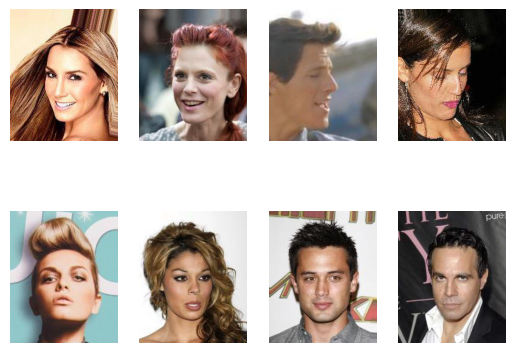

In [ ]:
FACES_PATH = "faces/img_align_celeba/img_align_celeba"

for i in range(1,9):
  img = Image.open(f'{FACES_PATH}/00000{i}.jpg')
  plt.subplot(2, 4, i)
  plt.axis('off')
  plt.imshow(img)

plt.show()

## load pretrained model

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

## Intro to CLIP

Load image using CLIP

In [ ]:
img = Image.open(f'{FACES_PATH}/000001.jpg')

clip_imgs = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
print("After image clip preprocessing the size is ", clip_imgs.size())

After image clip preprocessing the size is  torch.Size([1, 3, 224, 224])


Feature extractor of CLIP

In [ ]:
clip_img_encoding = clip_model.encode_image(clip_imgs)
print(clip_img_encoding.size())

torch.Size([1, 512])


Now, we want to see how to tokenize text and encoder it using clip

In [ ]:
text_list = [
    "An Angry man",
    "Smiling bald person",
    "Happy beautiful woman"
]
text_tokens = clip.tokenize(text_list).to(device)
print("Text tokens")
print(text_tokens[:,:10])
print("----------------------------")

clip_text_encodings = clip_model.encode_text(text_tokens).float()
print("For each text, encoding of 512 features ", clip_text_encodings.size())
print(clip_text_encodings)

Text tokens
tensor([[49406,   550,  9054,   786, 49407,     0,     0,     0,     0,     0],
        [49406,  9200, 14875,  2533, 49407,     0,     0,     0,     0,     0],
        [49406,   900,  1215,  2308, 49407,     0,     0,     0,     0,     0]],
       device='cuda:0', dtype=torch.int32)
----------------------------
For each text, encoding of 512 features  torch.Size([3, 512])
tensor([[-1.2091e-01,  4.8370e-02,  1.6748e-01,  ..., -4.6606e-01,
          4.8804e-01, -2.6685e-01],
        [-7.6660e-02,  4.8828e-04, -1.1377e-01,  ..., -1.3281e-01,
          9.7107e-02,  5.5969e-02],
        [ 2.5903e-01,  4.1626e-02, -4.3152e-02,  ..., -4.9805e-01,
         -2.3853e-01, -2.8976e-02]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)


In order to see which one of our text descriptions best describes the daisy, we can calculate the cosine similarity between the text encodings and the image encodings. <br/>
We will load three flowers, give each its encoding and will compare to the texts above

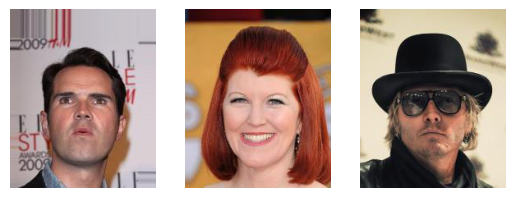

In [ ]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

imgs = [Image.open(f"{FACES_PATH}/{i}.jpg") for i in ["000069", "000174", "000154"]]
for i, img in enumerate(imgs):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
clip_img_encodings = get_img_encodings(imgs)    # torch.Tensor([3, 512])

text_list = [
    "A surprised man with black hair",
    "A woman smiling with red hair",
    "A person with black glasses and wears black hat"
]

text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens)   # torch.Tensor([3, 512])

clip_img_encodings /= clip_img_encodings.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)

similarity = clip_img_encodings @ clip_text_encodings.T

print(similarity)

tensor([[0.2695, 0.1113, 0.2220],
        [0.1642, 0.3076, 0.2156],
        [0.1747, 0.0907, 0.3110]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)


Well, is there a match?

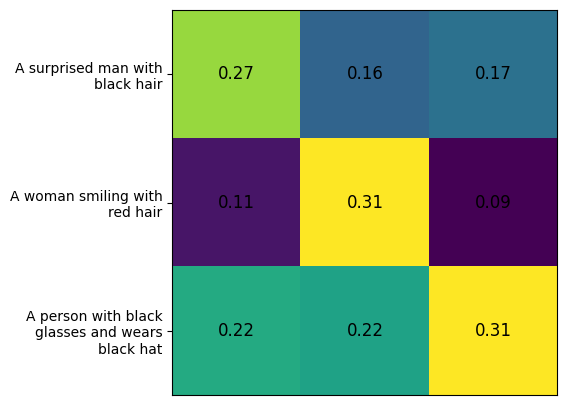

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=.1, hspace=0)

ax = fig.add_subplot(gs[1, :])
plt.imshow(similarity.detach().cpu().numpy().T, vmin=0.1, vmax=0.3)

labels = [ '\n'.join(wrap(text, 20)) for text in text_list ]
plt.yticks(range(len(text_tokens)), labels, fontsize=10)
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[x, y]:.2f}", ha="center", va="center", size=12)

Collabory: CLIP gives the most similar encoding of image to the most similar encoding of text.
Hence, we will train using the image encoding, but create new images using an encoding of text, hopefully it will work

## Proccess the data using clip

In [ ]:
IMG_SIZE = 32
IMG_CH = 3
BATCH_SIZE = 128
CLIP_FEATURES = 512

def crop_face(sample):
  return sample[:, 9:(9+32),4:(4+32)]

pre_transforms = transforms.Compose([
    transforms.Resize((50, 40)),
    transforms.ToTensor(),  # Scales data into [0,1]
    crop_face,
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

random_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])

With our current resources, we DO NOT want to encode ~60000 imaegs. Download the csv file from the task pdf. It contains the file paths, along with its preprocessed CLIP data.

In [ ]:
import glob
import csv

class MyDataset(Dataset):
    def __init__(self, csv_path='clip_data.csv'):
        self.imgs = []
        self.labels = torch.empty(
            len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
        )

        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                row[0] = row[0][9:]
                print(row[0])
                img = Image.open(row[0])
                self.imgs.append(pre_transforms(img).to(device))
                label = [float(x) for x in row[1:]]
                self.labels[idx, :] = torch.FloatTensor(label).to(device)

    def __getitem__(self, idx):
        return random_transforms(self.imgs[idx]), self.labels[idx]

    def __len__(self):
        return len(self.imgs)

data_paths = glob.glob(f'{FACES_PATH}/*.jpg', recursive=True)
train_data = MyDataset(csv_path='clip_O.csv')

faces_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

faces/img_align_celeba/img_align_celeba/000001.jpg
faces/img_align_celeba/img_align_celeba/000002.jpg
faces/img_align_celeba/img_align_celeba/000003.jpg
faces/img_align_celeba/img_align_celeba/000004.jpg
faces/img_align_celeba/img_align_celeba/000005.jpg
faces/img_align_celeba/img_align_celeba/000006.jpg
faces/img_align_celeba/img_align_celeba/000007.jpg
faces/img_align_celeba/img_align_celeba/000008.jpg
faces/img_align_celeba/img_align_celeba/000009.jpg
faces/img_align_celeba/img_align_celeba/000010.jpg
faces/img_align_celeba/img_align_celeba/000011.jpg
faces/img_align_celeba/img_align_celeba/000012.jpg
faces/img_align_celeba/img_align_celeba/000013.jpg
faces/img_align_celeba/img_align_celeba/000014.jpg
faces/img_align_celeba/img_align_celeba/000015.jpg
faces/img_align_celeba/img_align_celeba/000016.jpg
faces/img_align_celeba/img_align_celeba/000017.jpg
faces/img_align_celeba/img_align_celeba/000018.jpg
faces/img_align_celeba/img_align_celeba/000019.jpg
faces/img_align_celeba/img_alig

## Modify the architercture to bring context into our model

<img width="70%" src="https://sharon.srworkspace.com/dgm/context1.png"/>

In [ ]:
from collections import OrderedDict
import torch
import torch.nn as nn
from einops.layers.torch import Rearrange
import math

class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False),
            # nn.InstanceNorm2d(out_ch),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)
    
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [ ]:
class UNet(nn.Module):
    def __init__(self, T):
        super(UNet, self).__init__()
        img_chs = IMG_CH
        self.T = T
        down_chs = (32, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_embed_dim = 16
        c_embed_dim=CLIP_FEATURES # New

        small_group_size = 8 # New
        big_group_size = 32 # New

        # Inital convolution
        self.down0 = ResidualConvBlock(IMG_CH, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.temb_1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], IMG_CH, 3, 1, 1),
        )

        print("Num params: ", sum(p.numel() for p in self.parameters()))


    def forward(self, x, t, c, c_mask):
        # Implement here
        # Downsample
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        latent_vec = self.dense_emb(latent_vec)

        # Temporal embedding
        t = t.float() / self.T
        t_emb = self.sinusoidaltime(t)
        temb_1 = self.temb_1(t_emb)
        temb_2 = self.temb_2(t_emb)

        # Conditional embedding
        c_masked = c * c_mask
        c_emb1 = self.c_embed1(c_masked)
        c_emb2 = self.c_embed2(c_masked)

        # Upsample
        x = self.up0(latent_vec)
        x = self.up1(down2, x + temb_1 + c_emb1)
        x = self.up2(down1, x + temb_2 + c_emb2)
        x = self.out(torch.cat((down0, x), dim=1))

        return x

In [ ]:
class DDPM(pl.LightningModule):
    def __init__(self, T, method='cosine'):
        super(DDPM, self).__init__()
        self.T = T

        epsilon = 0.008
        if method == 'cosine':
            steps = torch.linspace(0, T, steps=T + 1).to(device)
            f_t = torch.cos(((steps / T + epsilon) / (1.0 + epsilon)) * math.pi * 0.5) ** 2
            self.Beta = torch.clip(1.0 - f_t[1:] / f_t[:T], 0.0, 0.999)

        elif method == 'linear':
            self.Beta = torch.linspace(1e-4, 2e-2, T).to(device)

        # Forward diffusion variables
        self.a = 1.0 - self.Beta
        self.a_bar = torch.cumprod(self.a, dim=0)

        self.net = UNet(T)

        # Logging
        self.train_loss = []
        self.train_loss_in_epoch = []

    def q(self, x_0, t):
        """
        Samples a new image from q
        Returns the noise applied to an image at timestep t
        x_0: the original image
        t: timestep
        """
        noise = torch.randn_like(x_0)
        alpha_bar = self.a_bar[t].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    @torch.no_grad()
    def reverse_q(self, x_t, t, e_t):
        beta_t = self.Beta[t].view(-1, 1, 1, 1)
        alpha_t = self.a[t].view(-1, 1, 1, 1)
        alpha_bar_t = self.a_bar[t].view(-1, 1, 1, 1)
        m = x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * e_t

        z = torch.where(t.view(-1, 1, 1, 1) > 0, torch.randn_like(x_t), torch.zeros_like(x_t))



        out = 1 / torch.sqrt(alpha_t) * m + beta_t * z
        return out

    def get_context_mask(self, c, drop_prob=0.1):
        c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
        return c_mask

    def get_loss(self, x_0, t, c):
        """
        Returns the loss between the true noise and the predicted noise
        x_0: the original image
        t: timestep
        """
        x_t, noise = self.q(x_0, t)
        c_mask = self.get_context_mask(c)
        e_t = self.net(x_t, t, c, c_mask)
        loss = F.mse_loss(noise, e_t)
        return loss

    @torch.no_grad()
    def sample(self, text_list, s=0.5):
        num_imgs = len(text_list)
        x_t = torch.randn((num_imgs, IMG_CH, IMG_SIZE, IMG_SIZE), device=self.device) * s

        c_tensor = torch.tensor(text_list, device=self.device).float()  # Ensure c_list is in correct format
        c_mask = self.get_context_mask(c_tensor)

        for t in reversed(range(self.T)):
            t_tensor = torch.full((num_imgs,), t, device=self.device, dtype=torch.long)
            e_t = self.net(x_t, t_tensor, c_tensor, c_mask)
            x_t = self.reverse_q(x_t, t_tensor, e_t)
        return x_t  # (|c_list|, IMG_CH, IMG_SIZE, IMG_SIZE)

    # Lightning Configurations

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, c = batch
        t = torch.randint(0, self.T, (BATCH_SIZE,), device=device)

        loss = self.get_loss(x, t, c)
        self.train_loss_in_epoch.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.tensor(self.train_loss_in_epoch).mean()
        self.train_loss_in_epoch = []

        self.log("train_loss", avg_loss, prog_bar=True)
        self.train_loss.append(avg_loss.detach().item())

        print(f"Epoch {self.current_epoch} | Loss: {avg_loss.detach().item()} ")
        sampled_data = self.sample(text_list, s=1.)
        show_imgs(sampled_data, grid=False)


## Train

This text list will be sampled at the end of each epoch, but does not affect the train.

In [ ]:
# Change me
text_list = [
    "A man wearing a white hat",
    "A woman in sun glasses",
    "A man with green hair and a blue shirt",
    "A sad woman with blue eyes"
]

def get_text_embeddings(text_list):
    model, preprocess = clip.load("ViT-B/32", device=device)
    text_embeddings = []
    for text in text_list:
        with torch.no_grad():
            text_embedding = model.encode_text(clip.tokenize([text]).to(device))
        text_embeddings.append(text_embedding.squeeze(0).cpu().numpy())
    return text_embeddings


text_list = get_text_embeddings(text_list)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params | Mode 
--------------------------------------
0 | net  | UNet | 3.0 M  | train
--------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
12.131    Total estimated model params size (MB)


Num params:  3032835


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 | Loss: 0.12700536847114563 


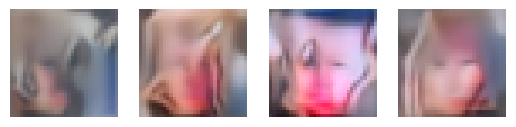

Epoch 1 | Loss: 0.06511068344116211 


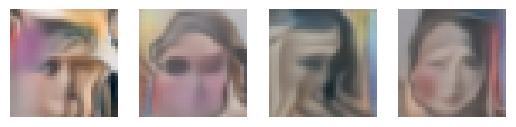

Epoch 2 | Loss: 0.058751098811626434 


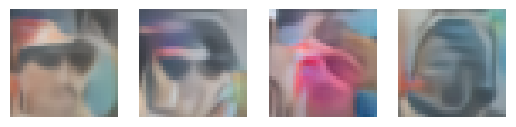

Epoch 3 | Loss: 0.055795907974243164 


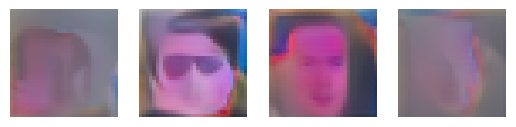

Epoch 4 | Loss: 0.053903866559267044 


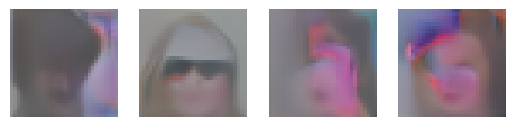

Epoch 5 | Loss: 0.05199224501848221 


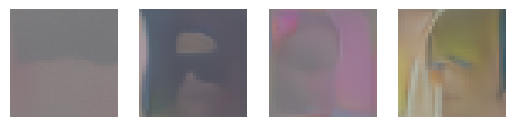

Epoch 6 | Loss: 0.05194956809282303 


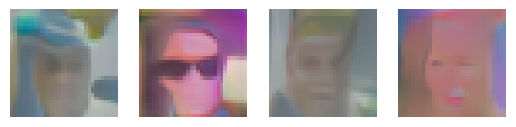

Epoch 7 | Loss: 0.050935693085193634 


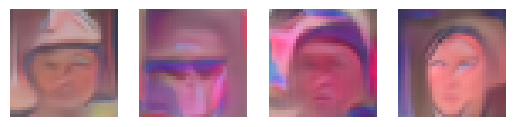

Epoch 8 | Loss: 0.05049453675746918 


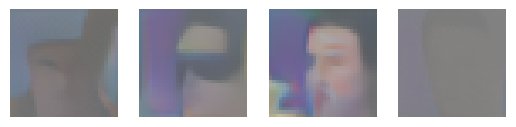

Epoch 9 | Loss: 0.05004046857357025 


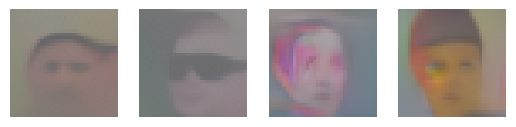

Epoch 10 | Loss: 0.049671072512865067 


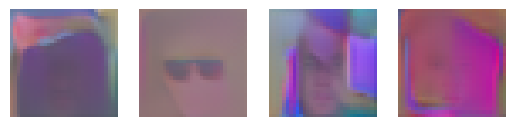

Epoch 11 | Loss: 0.04921542853116989 


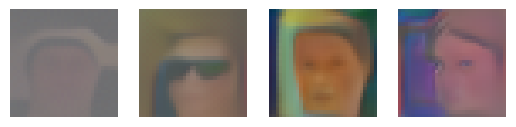

Epoch 12 | Loss: 0.04910784214735031 


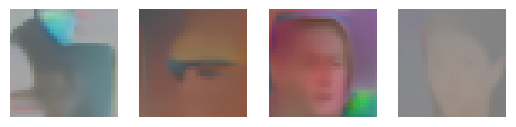

Epoch 13 | Loss: 0.04879825562238693 


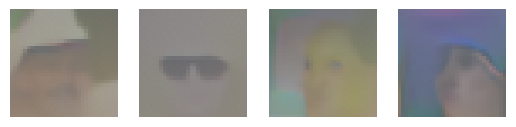

Epoch 14 | Loss: 0.048863910138607025 


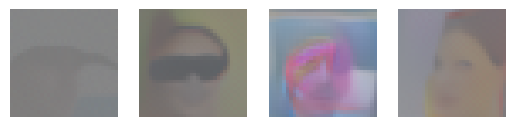

Epoch 15 | Loss: 0.04902585223317146 


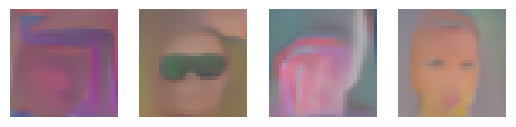

Epoch 16 | Loss: 0.048490215092897415 


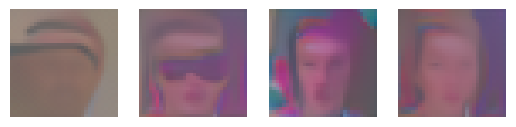

Epoch 17 | Loss: 0.048607662320137024 


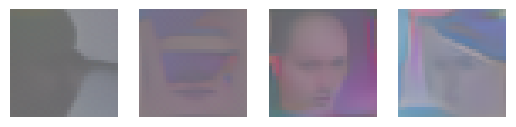

Epoch 18 | Loss: 0.047902725636959076 


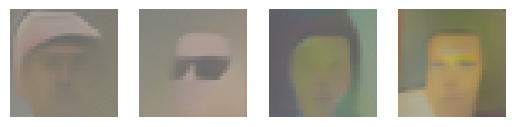

Epoch 19 | Loss: 0.048104289919137955 


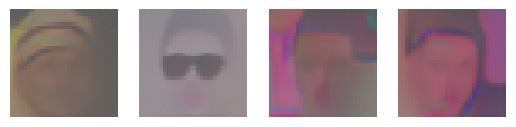

Epoch 20 | Loss: 0.04721911624073982 


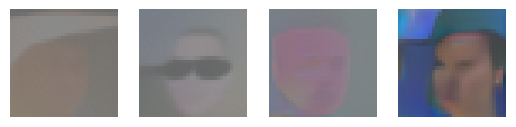

Epoch 21 | Loss: 0.04779062792658806 


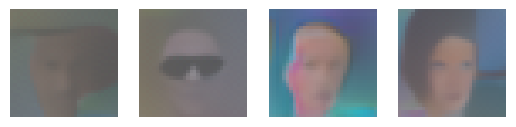

Epoch 22 | Loss: 0.047205980867147446 


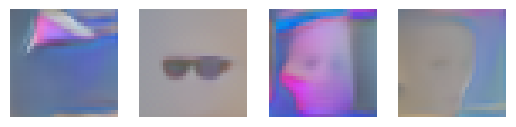

Epoch 23 | Loss: 0.04745090380311012 


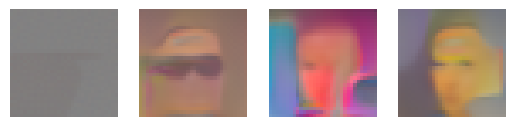

Epoch 24 | Loss: 0.04764208197593689 


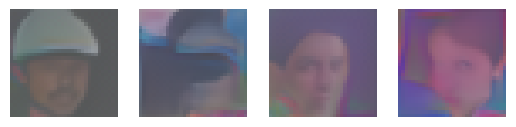

Epoch 25 | Loss: 0.047301966696977615 


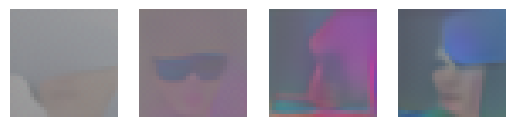

Epoch 26 | Loss: 0.04714342579245567 


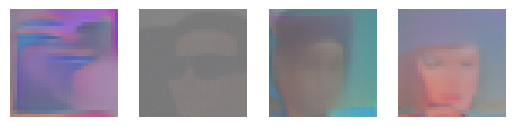

Epoch 27 | Loss: 0.047070782631635666 


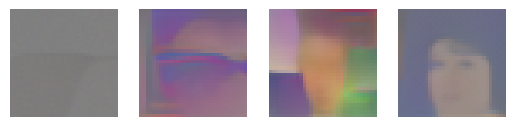

Epoch 28 | Loss: 0.046860139816999435 


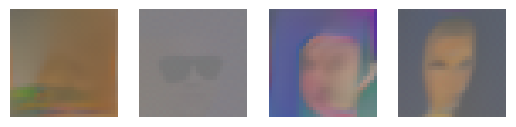

Epoch 29 | Loss: 0.046815164387226105 


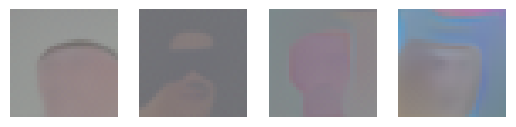

Epoch 30 | Loss: 0.04665651544928551 


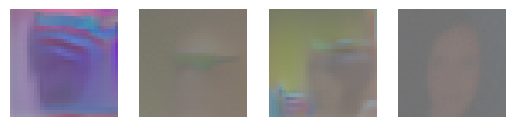

Epoch 31 | Loss: 0.04632141813635826 


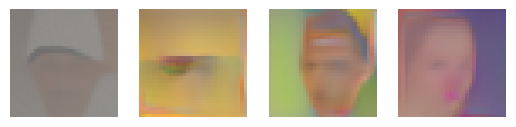

Epoch 32 | Loss: 0.04639200493693352 


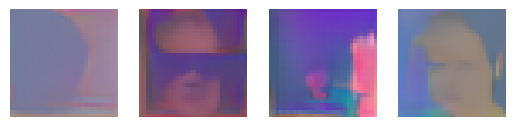

Epoch 33 | Loss: 0.046270765364170074 


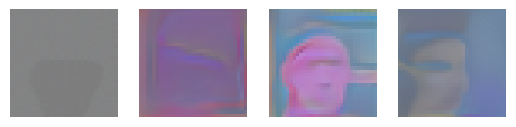

Epoch 34 | Loss: 0.04617942497134209 


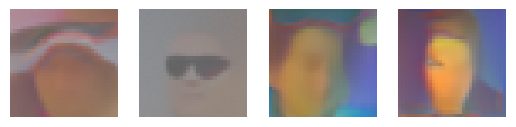

Epoch 35 | Loss: 0.04594351723790169 


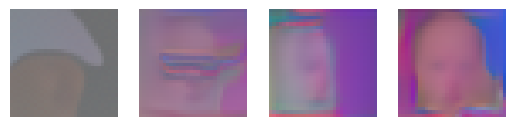

Epoch 36 | Loss: 0.045674633234739304 


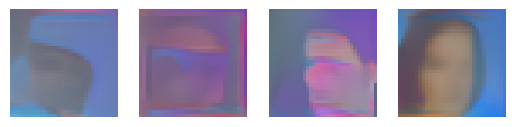

Epoch 37 | Loss: 0.046910133212804794 


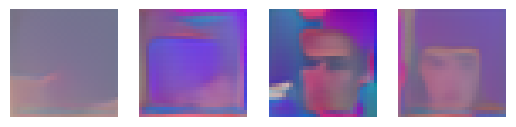

Epoch 38 | Loss: 0.045886535197496414 


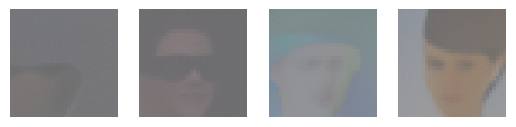

Epoch 39 | Loss: 0.04623579606413841 


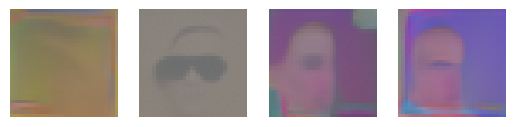

Epoch 40 | Loss: 0.045973241329193115 


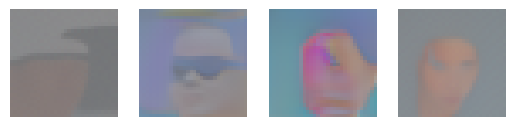

Epoch 41 | Loss: 0.04608152434229851 


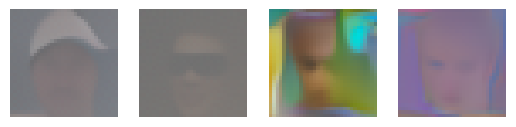

Epoch 42 | Loss: 0.04605938866734505 


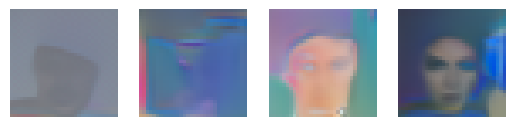

Epoch 43 | Loss: 0.04573463276028633 


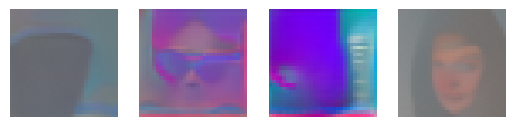

Epoch 44 | Loss: 0.04559752717614174 


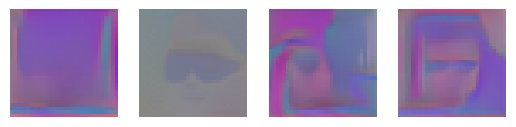

Epoch 45 | Loss: 0.04619547352194786 


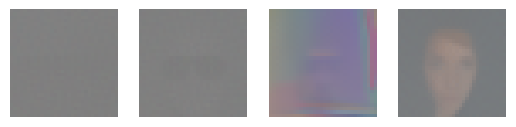

Epoch 46 | Loss: 0.04547937214374542 


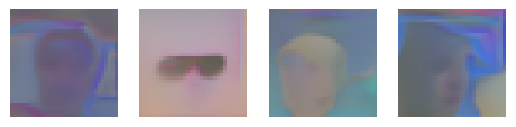

Epoch 47 | Loss: 0.04572713375091553 


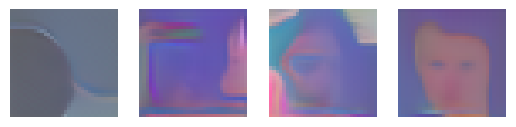

Epoch 48 | Loss: 0.04583711177110672 


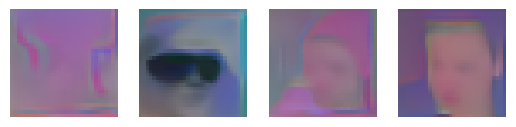

Epoch 49 | Loss: 0.045654188841581345 


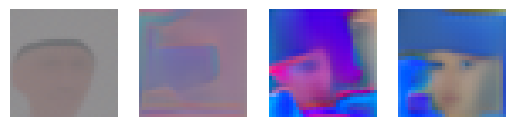

`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join("DDPM"),
        devices=1,
        max_epochs=50,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="train_loss"),
            LearningRateMonitor("epoch")
        ]
    )

    model = DDPM(**kwargs)
    model.train()
    trainer.fit(model, faces_dataloader)
    model.eval()
    return model

model = train_model(T=300, method='linear').to(device)

## Final evaluation

In [ ]:
text_list_new1 = [
    "A sad man with long hair",
]

text_list_new2 = [
    "A smiling woman with green eyes",
]

text_list_new1 = get_text_embeddings(text_list_new1)
text_list_new2 = get_text_embeddings(text_list_new2)

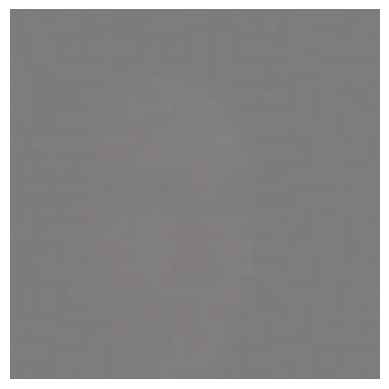

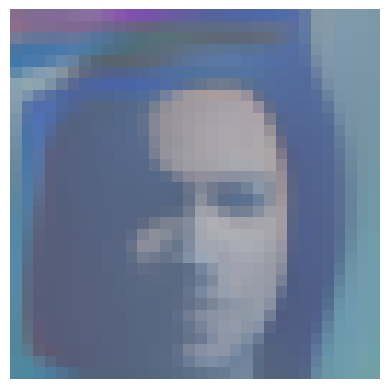

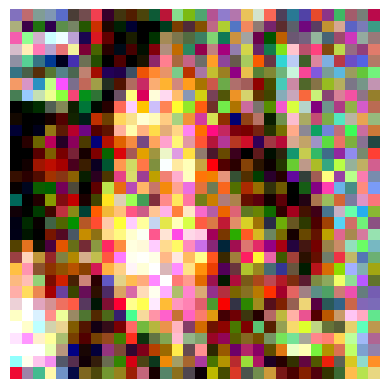

In [ ]:
sampled_data1 = model.sample(text_list_new1, s=0)
show_imgs(sampled_data1, grid=False)
sampled_data2 = model.sample(text_list_new1, s=1.5)
show_imgs(sampled_data2, grid=False)
sampled_data3 = model.sample(text_list_new1, s=2)
show_imgs(sampled_data3, grid=False)

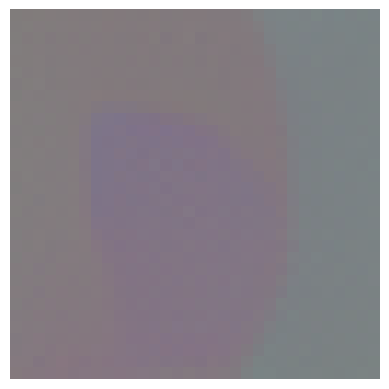

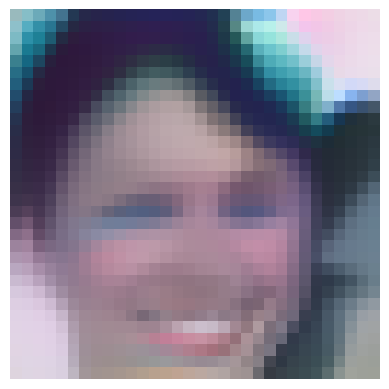

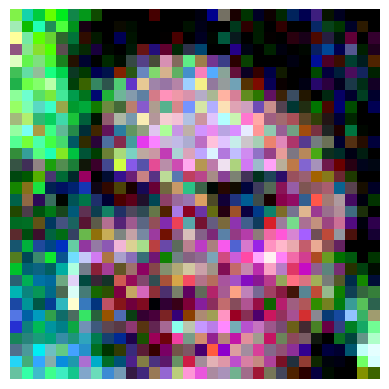

In [ ]:
sampled_data1 = model.sample(text_list_new2, s=0)
show_imgs(sampled_data1, grid=False)
sampled_data2 = model.sample(text_list_new2, s=1.5)
show_imgs(sampled_data2, grid=False)
sampled_data3 = model.sample(text_list_new2, s=2)
show_imgs(sampled_data3, grid=False)